# Extrapolation of a standard plasma profiles in tokamaks

This notebook allows the extrapolation of electron density and temperature profiles 

\begin{equation*}
 n_e = n_e(\rho), \qquad T_e = T_e(\rho)
\end{equation*}

where $\rho = \sqrt{\psi}$ and $\psi$ is the normalized poloidal flux. Generally, the profiles are given as an arrays

\begin{equation*}
 n_{e, i} = n_e(\rho_i), \qquad T_{e, j} = T_e(\rho_j),
\end{equation*}

over (possibly different uniform grid $\rho_i = \rho_{\mathrm{off}, n} + i h$ for $i \in \{0, \ldots, N \}$, $h>0$, and 
$\rho_j = \rho_{\mathrm{off}, T} + j k$ for $j\in \{0, \ldots, M\}$, $k>0$, with possible offsets 
$\rho_{\mathrm{off}, n}, \rho_{\mathrm{off},T} \geq 0$. 


Such profiles are extended from the point with indices $i_\mathrm{start} \leq N$ and $j_\mathrm{start} \leq M$ 
up to the given common value $\rho_\mathrm{max}$ of the poloidal flux coordinate. This implies that the profiles are 
repladed by model functions in the range $\rho > \rho_{i_\mathrm{start}}$ and $\rho > \rho_{j_\mathrm{start}}$, respectively,
and thus the indices $i_\mathrm{start}$ and $j_\mathrm{start}$ must be large enough for the data in the plasma core to be
unchanged.


**Usage:**

The user should change the input file name and the parameters below as appropriate and run the whole notebook. 
Plots are meant to give an indication about the quality of the result. 

# Read data and preliminary definitions

First the density profile is read from the filed 'ne.dat' and the temperature profile from 'Te.dat'. The data format for the density is 
the standard format used by the ```TORBEAM``` code, namely, an ```ASCII``` file with

$N$

$\rho_0$ $n_{e,0}$

$\rho_1$ $n_{e,1}$

...                 

$\rho_{N-1}$ $n_{e,N-1}$

and analogously for the electron temperature. The first line is skipped when data are loaded by the ```numpy``` function 
```loadtxt```.

In [71]:
# Working directory (must contain the original data files)
working_dir = './'
ne_filename = 'p_ne.txt'
Te_filename = 'p_Te.txt'

In [72]:
# Import statements
from pylab import *
import math
from scipy.optimize import curve_fit

%matplotlib inline

In [73]:
# Load density data
data_ne = loadtxt(working_dir+'/'+ne_filename, skiprows=0)
rho_ne = data_ne[:,0]
Ne = data_ne[:,1]
# Load temperature data
data_Te = loadtxt(working_dir+'/'+Te_filename, skiprows=0)
rho_Te = data_Te[:,0]
Te = data_Te[:,1]

In [74]:
# If needed, convert the data to the WKBeam units 
# (i.e., Ne must be in 10^13 cm^-3 = 10^19 m^-3, while Te must in KeV)
ne_conv_factor = 1e-19
Te_conv_factor = 1

Ne *= ne_conv_factor
Te *= Te_conv_factor

It is expected that $\rho_i$ is given in strictly increasing order, i.e., $\rho_i < \rho_j$ for indices $i < j$. It may happpen that this is not the case. Then the data are  flipped.

In [75]:
# Check the order of the radial coordinate and flip the data if needed.
# ... general function ...
def flip_data(rho, data):
    """ Check if the order of the data is ok, and, if not, flip the data
    appropriately."""
    if rho[0] > rho[1]:
        flipped_rho = flipud(rho)
        flipped_data = flipud(data)
        return flipped_rho, flipped_data
    else:
        return rho, data
# ... density data ...
rho_ne, Ne = flip_data(rho_ne, Ne)
# ... temperature data ...
rho_Te, Te = flip_data(rho_Te, Te)

# Fitting funtion

For both density and temperature profiles the data on the outer part of profiles are fitted to the model

\begin{equation*}
F_{a,b,c,d}(\rho) = a \Big(\frac{1}{2} - \frac{1}{\pi} \arctan(\frac{\rho - c}{b} ) \Big) 
\begin{cases}
    \exp\big( -(\rho - c)^2 / d^2 \big), & \text{for $\rho > c$}, \\\\
    1, & \text{for $\rho \leq c$},
\end{cases}
\end{equation*}

where $a, b, c, d \in \mathbb{R}$ are parameters of the fit, for which ```curve_fit``` from ```scipy.interpolate``` is used.

In [76]:
# Fit function  
def func(x,a,b,c,d):
    result = empty([x.size])
    for i in range(0,x.size):
        if x[i] > c:
            result[i] = (0.5 - math.atan((x[i]-c)/b) / math.pi)*a*\
                         math.exp(-(x[i]-c)**2 / d**2)
        else:
            result[i] = (0.5 - math.atan((x[i]-c)/b) / math.pi)*a
    return result

## Set parameters

In this section, the parameter for the extrapolation should be defined. Before setting the parameters, one should check the data array.

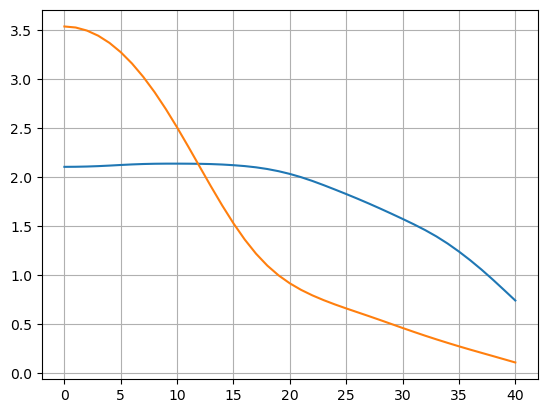

In [77]:
# Plot data arrays vs their index, not the physical coordinate
x = np.arange(0, 140, 1)
figure(0)
# ... density ...
plot(Ne);
plot(Te);
grid(True)

In [78]:
len(Te)

41

In [79]:
# Parameters for the density profile
IndexIstart = 35
IndexIstop = rho_ne.size
fit_parameter_seed_ne = [0.5, 0.5, 1.1, 0.1]
# Parameters for the temperature profile
IndexJstart = 35
IndexJstop = rho_Te.size
fit_parameter_seed_Te = [0.5, 0.5, 1.1, 0.1]
# Common parameters
rho_max = 1.4
nmbrAdditionalPoints = math.ceil((rho_max - rho_ne[IndexIstart])* IndexIstart/ rho_ne[IndexIstart])

# Perform the calculations

For both the density and temperature profiles the following operations are performed:

1. Fit the model $F_{a,b,c,d}(\rho)$ to the desired slice of data. This gives the values of the fit parameters $a,b,c,d$.

2. Extend the data by appending additional point after the start indices $i_\mathrm{start}$ and $j_\mathrm{start}$. 

In [80]:
# --- Extend Denisty ---

# Best fit for the density
p_ne, info = curve_fit(func, 
                           rho_ne[IndexIstart:IndexIstop], 
                           Ne[IndexIstart:IndexIstop])
print(info)
# Extrapolated points for the density
rho_ne_cut = rho_ne[0:IndexIstart]
Ne_cut = Ne[0:IndexIstart]
rho_ne_new = linspace(rho_ne[IndexIstart], rho_max, nmbrAdditionalPoints)
Ne_new = func(rho_ne_new, p_ne[0], p_ne[1], p_ne[2], p_ne[3]) 

# Combine unchanged data with the extrapolated profile
rho_ne_extended = append(rho_ne_cut, rho_ne_new, axis=0)
Ne_extended = append(Ne_cut, Ne_new, axis=0)

# --- Extend Temperature ---

# Best fit for the temperature
p_Te, info = curve_fit(func, 
                           rho_Te[IndexJstart:IndexJstop], 
                           Te[IndexJstart:IndexJstop],
                           fit_parameter_seed_Te)
print(info)
# Extrapolated points for the temperature
rho_Te_cut = rho_Te[0:IndexJstart]
Te_cut = Te[0:IndexJstart]
rho_Te_new = linspace(rho_Te[IndexJstart], rho_max, nmbrAdditionalPoints)
Te_new = func(rho_Te_new, p_Te[0], p_Te[1], p_Te[2], p_Te[3]) 

# Combine unchanged data with the extrapolated profile
rho_Te_extended = append(rho_Te_cut, rho_Te_new, axis=0)
Te_extended = append(Te_cut, Te_new, axis=0)

[[ 9.70442282e+01 -2.63131916e+07  1.25928573e+03 -1.00363885e+01]
 [-2.63131916e+07  7.13480637e+12 -3.41454637e+08  2.72140731e+06]
 [ 1.25928573e+03 -3.41454637e+08  1.63411960e+04 -1.30240028e+02]
 [-1.00363885e+01  2.72140731e+06 -1.30240028e+02  1.03804672e+00]]
[[ 0.25039064  0.10808682 -0.09498415 -0.0650894 ]
 [ 0.10808682  0.04669506 -0.04100138 -0.02822694]
 [-0.09498415 -0.04100138  0.03603296  0.02467802]
 [-0.0650894  -0.02822694  0.02467802  0.0175978 ]]


### Plots of the original and extrapolated profiles

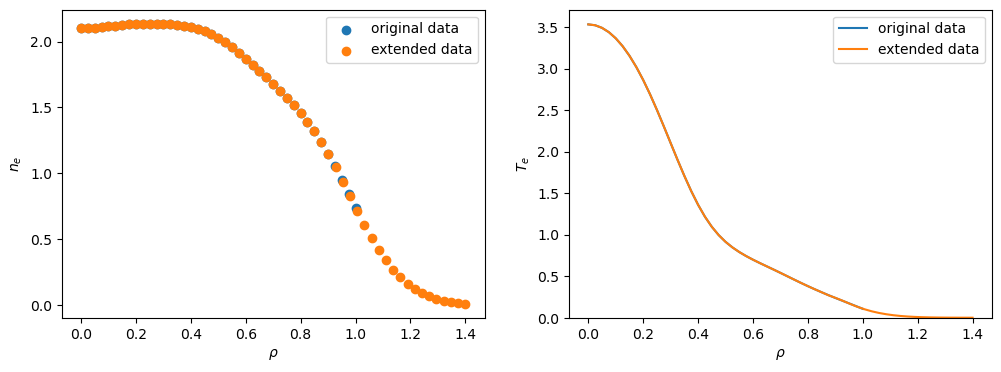

In [81]:
figure(1, figsize=(12,4))
# Density
subplot(121)
scatter(rho_ne, Ne);
scatter(rho_ne_extended, Ne_extended);
xlabel(r'$\rho$')
ylabel(r'$n_e$')
legend(('original data', 'extended data'));
# Temperature
subplot(122)
plot(rho_Te, Te);
plot(rho_Te_extended, Te_extended);
xlabel(r'$\rho$')
ylabel(r'$T_e$')
ylim(0)

legend(('original data', 'extended data'));

### Save data in the appropriate format 

When the user is satisfied with the quality of the extrapolation, here the extrapolated data can be saved in the ```TORBEAM``` format described above.

In [82]:
# Output files
Ne_filename = working_dir + '/ne.dat.extended'
Te_filename = working_dir + '/Te.dat.extended'

# Open output files
Ne_file = open(Ne_filename, 'ab')
Te_file = open(Te_filename, 'ab')

# Clear the content of both files when not already empty
Ne_file.seek(0); Ne_file.truncate()
Te_file.seek(0); Te_file.truncate()

# Export the data
data = array([rho_ne_extended, Ne_extended])
savetxt(Ne_file, array([rho_ne_extended.size], dtype=int), fmt='%i')
savetxt(Ne_file, data.T)
#
data = array([rho_Te_extended, Te_extended])
savetxt(Te_file, array([rho_Te_extended.size], dtype=int), fmt='%i')
savetxt(Te_file, data.T)

# Close files
Ne_file.close()
Te_file.close()

End of notebook.